In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Optional


import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import catboost as cb
from scipy.stats import skew, kurtosis

%matplotlib inline


import warnings
warnings.simplefilter("ignore")

In [2]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')

In [3]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [4]:
df_test.head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [7]:
df_application.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [9]:
apps_groupby = df_application.groupby("APPLICATION_NUMBER", as_index=False)
previous_app_counts = apps_groupby["PREV_APPLICATION_NUMBER"].count()
previous_app_counts = previous_app_counts.rename(columns={
    "PREV_APPLICATION_NUMBER": "PREV_APPS_COUNT"
})
previous_app_counts.head(n=3)

,APPLICATION_NUMBER,PREV_APPS_COUNT
0,123423340,1
1,123423341,1
2,123423342,3


In [10]:
df_train = df_train.merge(
    previous_app_counts, how="left", on="APPLICATION_NUMBER"
)
df_train["PREV_APPS_COUNT"] = df_train["PREV_APPS_COUNT"].fillna(0)
df_train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT
0,123687442,0,Cash,3.0
1,123597908,1,Cash,4.0


In [11]:
df_test = df_test.merge(
    previous_app_counts, how="left", on="APPLICATION_NUMBER"
)
df_test["PREV_APPS_COUNT"] = df_test["PREV_APPS_COUNT"].fillna(0)
df_test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT
0,123724268,Cash,4.0
1,123456549,Cash,2.0


In [12]:
def plot_kde_target(feature_name: str, data: pd.DataFrame):
    """
    Визуализация функции распределения признаков в зависимости
    от значения целевой переменной на обучающей выборке.
    Вывод коэффициента корреляции между значением признака
    и значением целевой переменной, вывод медианы
    значений признака в разрезе целевой переменной.

    Parameters
    ----------
    faeture_name: str
        Название анализируемого признака.

    data: pandas.core.frame.DataFrame
        Матрица признаков для обучения.

    """
    corr = data["TARGET"].corr(data[feature_name])

    mask = data["TARGET"] == 1
    avg_target = data.loc[mask, feature_name].median()
    avg_non_target = data.loc[~mask, feature_name].median()

    fig = plt.figure(figsize=(12, 6))
    plt.title(f"{feature_name} Distribution", size=14)
    sns.kdeplot(data.loc[mask, feature_name], linewidth=3, color="blue", label="TARGET = 1")
    sns.kdeplot(data.loc[~mask, feature_name], linewidth=3, color="green", label="TARGET = 0")
    plt.legend(loc="best", fontsize=14)
    plt.xlabel(feature_name, size=14)
    plt.ylabel("Density", size=14)

    print(f"The correlation between {feature_name} and target = {round(corr, 4)}")
    print(f"Median-value for default-loan = {round(avg_target, 4)}")
    print(f"Median-value for non default-loan = {round(avg_target, 4)}")

The correlation between PREV_APPS_COUNT and target = 0.0008
Median-value for default-loan = 4.0
Median-value for non default-loan = 4.0


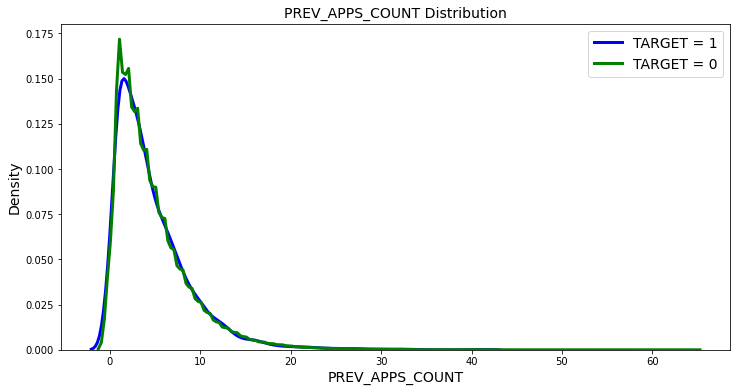

In [13]:
plot_kde_target("PREV_APPS_COUNT", df_train)

In [14]:
stats = ["count", "mean", "min", "max", "std"]
previous_app_numerical = apps_groupby["AMT_APPLICATION"].agg(stats).reset_index()
previous_app_numerical = previous_app_numerical.rename(
    columns={name: f"PREV_AMT_APPLICATION_{name.upper()}" for name in stats}
)
previous_app_numerical.head(n=3)

,APPLICATION_NUMBER,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD
0,123423340,1,24835.5,24835.5,24835.5,NaN
1,123423341,1,179055.0,179055.0,179055.0,NaN
2,123423342,3,435436.5,68809.5,900000.0,424161.620549


In [15]:
df_train = df_train.merge(
    previous_app_numerical, how="left", on="APPLICATION_NUMBER"
)
df_train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD
0,123687442,0,Cash,3.0,3.0,68787.18,62058.6,72634.14,5847.077214
1,123597908,1,Cash,4.0,4.0,331908.75,75510.0,495000.00,203148.223734


In [16]:
df_test = df_test.merge(
    previous_app_numerical, how="left", on="APPLICATION_NUMBER"
)
df_test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD
0,123724268,Cash,4.0,4.0,143007.750,0.00,450000.0,212592.488673
1,123456549,Cash,2.0,2.0,321183.585,102367.17,540000.0,309453.141763


In [17]:
previous_app_numerical_advanced_features = apps_groupby["AMT_APPLICATION"].agg([kurtosis, skew])
previous_app_numerical_advanced_features = previous_app_numerical_advanced_features.reset_index()
previous_app_numerical_advanced_features = previous_app_numerical_advanced_features.rename(
    columns={name: f"PREV_AMT_APPLICATION_{name.upper()}" for name in ["kurtosis", "skew"]}
)
previous_app_numerical_advanced_features.head(n=3)

,APPLICATION_NUMBER,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW
0,123423340,-3.0,0.000000
1,123423341,-3.0,0.000000
2,123423342,-1.5,0.401566


In [18]:
df_train = df_train.merge(
    previous_app_numerical_advanced_features, how="left", on="APPLICATION_NUMBER"
)
df_train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW
0,123687442,0,Cash,3.0,3.0,68787.18,62058.6,72634.14,5847.077214,-1.500000,-0.685485
1,123597908,1,Cash,4.0,4.0,331908.75,75510.0,495000.00,203148.223734,-1.496772,-0.391133


In [19]:
df_test = df_test.merge(
    previous_app_numerical_advanced_features, how="left", on="APPLICATION_NUMBER"
)
df_test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW
0,123724268,Cash,4.0,4.0,143007.750,0.00,450000.0,212592.488673,-0.885377,9.243167e-01
1,123456549,Cash,2.0,2.0,321183.585,102367.17,540000.0,309453.141763,-2.000000,-3.817863e-16


In [20]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [21]:
aggs = {
    "AMT_APPLICATION": [np.mean, np.std, np.sum, "max"],
    "CNT_PAYMENT": [np.mean]
}

mask = df_application["NAME_CONTRACT_STATUS"] == "Approved"
stats = create_numerical_aggs(
    df_application[mask], groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="PREV_APP_", suffix="_APPROVED_APPS"
)
stats.head(n=2)

,APPLICATION_NUMBER,PREV_APP_AMT_APPLICATION_MEAN_APPROVED_APPS,PREV_APP_AMT_APPLICATION_STD_APPROVED_APPS,PREV_APP_AMT_APPLICATION_SUM_APPROVED_APPS,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS
0,123423340,24835.5,NaN,24835.5,24835.5,8.0
1,123423341,179055.0,NaN,179055.0,179055.0,24.0


In [22]:
df_train = df_train.merge(
    stats, how="left", on="APPLICATION_NUMBER"
)
df_train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW,PREV_APP_AMT_APPLICATION_MEAN_APPROVED_APPS,PREV_APP_AMT_APPLICATION_STD_APPROVED_APPS,PREV_APP_AMT_APPLICATION_SUM_APPROVED_APPS,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS
0,123687442,0,Cash,3.0,3.0,68787.18,62058.6,72634.14,5847.077214,-1.500000,-0.685485,68787.18,5847.077214,206361.54,72634.14,10.666667
1,123597908,1,Cash,4.0,4.0,331908.75,75510.0,495000.00,203148.223734,-1.496772,-0.391133,277545.00,210169.686979,832635.00,495000.00,19.333333


In [23]:
df_test = df_test.merge(
    stats, how="left", on="APPLICATION_NUMBER"
)
df_test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW,PREV_APP_AMT_APPLICATION_MEAN_APPROVED_APPS,PREV_APP_AMT_APPLICATION_STD_APPROVED_APPS,PREV_APP_AMT_APPLICATION_SUM_APPROVED_APPS,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS
0,123724268,Cash,4.0,4.0,143007.750,0.00,450000.0,212592.488673,-0.885377,9.243167e-01,286015.500,231909.103919,572031.00,450000.0,6.0
1,123456549,Cash,2.0,2.0,321183.585,102367.17,540000.0,309453.141763,-2.000000,-3.817863e-16,321183.585,309453.141763,642367.17,540000.0,24.0


In [24]:
def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

In [25]:
stats = create_categorical_aggs(
    df_application, groupby_id="APPLICATION_NUMBER", features=["NAME_CONTRACT_STATUS"], prefix=""
)
stats.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123423340,1.0,1,0.0,0,0.0,0,0.0,0
1,123423341,1.0,1,0.0,0,0.0,0,0.0,0


In [26]:
df_train = df_train.merge(
    stats, how="left", on="APPLICATION_NUMBER"
)
df_train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,...,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123687442,0,Cash,3.0,3.0,68787.18,62058.6,72634.14,5847.077214,-1.500000,...,72634.14,10.666667,1.00,3.0,0.0,0.0,0.00,0.0,0.0,0.0
1,123597908,1,Cash,4.0,4.0,331908.75,75510.0,495000.00,203148.223734,-1.496772,...,495000.00,19.333333,0.75,3.0,0.0,0.0,0.25,1.0,0.0,0.0


In [27]:
df_test = df_test.merge(
    stats, how="left", on="APPLICATION_NUMBER"
)
df_test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW,...,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123724268,Cash,4.0,4.0,143007.750,0.00,450000.0,212592.488673,-0.885377,9.243167e-01,...,450000.0,6.0,0.5,2.0,0.5,2.0,0.0,0.0,0.0,0.0
1,123456549,Cash,2.0,2.0,321183.585,102367.17,540000.0,309453.141763,-2.000000,-3.817863e-16,...,540000.0,24.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df_train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,...,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123687442,0,Cash,3.0,3.0,68787.180000,62058.600,72634.140,5847.077214,-1.500000,...,72634.140,10.666667,1.000000,3.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,123597908,1,Cash,4.0,4.0,331908.750000,75510.000,495000.000,203148.223734,-1.496772,...,495000.000,19.333333,0.750000,3.0,0.000000,0.0,0.250000,1.0,0.0,0.0
2,123526683,0,Cash,6.0,6.0,353857.500000,0.000,1395000.000,551676.129480,0.171432,...,1395000.000,18.000000,0.666667,4.0,0.166667,1.0,0.166667,1.0,0.0,0.0
3,123710391,1,Cash,2.0,2.0,61206.750000,21555.000,100858.500,56076.042622,-2.000000,...,100858.500,14.000000,1.000000,2.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,123590329,1,Cash,9.0,9.0,266842.000000,0.000,697500.000,253591.201736,-1.214855,...,105381.000,9.000000,0.222222,2.0,0.111111,1.0,0.666667,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,5.0,5.0,66922.866000,28380.330,90000.000,25710.340396,-1.121926,...,90000.000,6.500000,0.800000,4.0,0.000000,0.0,0.200000,1.0,0.0,0.0
110089,123672463,0,Cash,13.0,13.0,68150.526923,0.000,270000.000,79144.710608,1.232363,...,270000.000,8.250000,0.615385,8.0,0.153846,2.0,0.230769,3.0,0.0,0.0
110090,123723001,0,Cash,2.0,2.0,30363.750000,26482.500,34245.000,5488.916389,-2.000000,...,34245.000,9.000000,1.000000,2.0,0.000000,0.0,0.000000,0.0,0.0,0.0
110091,123554358,0,Cash,2.0,2.0,299340.000000,261180.000,337500.000,53966.389540,-2.000000,...,261180.000,18.000000,0.500000,1.0,0.000000,0.0,0.500000,1.0,0.0,0.0


In [29]:
df_test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APPS_COUNT,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW,...,PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS,PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123724268,Cash,4.0,4.0,143007.750000,0.00,450000.0,212592.488673,-0.885377,9.243167e-01,...,450000.0,6.000000,0.500000,2.0,0.500000,2.0,0.00,0.0,0.0,0.0
1,123456549,Cash,2.0,2.0,321183.585000,102367.17,540000.0,309453.141763,-2.000000,-3.817863e-16,...,540000.0,24.000000,1.000000,2.0,0.000000,0.0,0.00,0.0,0.0,0.0
2,123428178,Credit Card,8.0,8.0,386057.250000,93897.00,900000.0,259724.348864,-0.051770,8.454909e-01,...,900000.0,16.400000,0.625000,5.0,0.125000,1.0,0.25,2.0,0.0,0.0
3,123619984,Cash,1.0,1.0,397755.000000,397755.00,397755.0,NaN,-3.000000,0.000000e+00,...,397755.0,36.000000,1.000000,1.0,0.000000,0.0,0.00,0.0,0.0,0.0
4,123671104,Cash,5.0,5.0,50146.956000,0.00,130545.0,48988.108230,-0.379945,9.111541e-01,...,130545.0,9.333333,0.600000,3.0,0.000000,0.0,0.20,1.0,0.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,6.0,6.0,82500.000000,0.00,450000.0,180935.071227,1.126538,1.750770e+00,...,450000.0,24.000000,0.333333,2.0,0.666667,4.0,0.00,0.0,0.0,0.0
165137,123536402,Cash,2.0,2.0,181498.500000,119997.00,243000.0,86976.255406,-2.000000,0.000000e+00,...,243000.0,10.000000,1.000000,2.0,0.000000,0.0,0.00,0.0,0.0,0.0
165138,123718238,Cash,10.0,10.0,231750.000000,0.00,450000.0,107713.160756,1.729479,-1.879781e-01,...,450000.0,18.000000,0.500000,5.0,0.000000,0.0,0.50,5.0,0.0,0.0
165139,123631557,Cash,7.0,7.0,260456.785714,23197.50,495000.0,174056.486729,-1.307298,8.774091e-02,...,495000.0,23.142857,1.000000,7.0,0.000000,0.0,0.00,0.0,0.0,0.0


In [43]:
# 4.4. Экспорт измененных таблиц
import csv
filename = 'train_app_upd_1.csv'
df_train.to_csv(filename, index=None)
filename = 'test_app_upd_1.csv'
df_test.to_csv(filename, index=None)

In [30]:
erwerewr

NameError: name 'erwerewr' is not defined

In [31]:
correlation = df_train.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                                         1.000000
NAME_CONTRACT_STATUS_CANCELED_RATIO            0.003580
PREV_AMT_APPLICATION_SKEW                      0.002560
NAME_CONTRACT_STATUS_REFUSED_RATIO             0.002281
PREV_AMT_APPLICATION_KURTOSIS                  0.001532
NAME_CONTRACT_STATUS_REFUSED_TOTAL             0.001185
PREV_APPS_COUNT                                0.000785
PREV_AMT_APPLICATION_COUNT                     0.000734
NAME_CONTRACT_STATUS_CANCELED_TOTAL            0.000647
NAME_CONTRACT_STATUS_APPROVED_TOTAL           -0.000030
PREV_AMT_APPLICATION_MAX                      -0.000259
NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL       -0.000339
PREV_AMT_APPLICATION_STD                      -0.000471
PREV_APP_CNT_PAYMENT_MEAN_APPROVED_APPS       -0.001008
NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO       -0.002052
PREV_APP_AMT_APPLICATION_SUM_APPROVED_APPS    -0.002161
APPLICATION_NUMBER                            -0.002239
PREV_APP_AMT_APPLICATION_MAX_APPROVED_APPS    -0

In [33]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

def prepare_data(X, categorical, to_drop):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed

In [34]:
cb_params_10000 = {
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 300,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

to_drop = [
    "TARGET",
]

categorical = df_train.select_dtypes(include=["object"]).columns.tolist()

In [35]:
x_train, x_valid = train_test_split(
    df_train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    df_train["TARGET"], train_size=0.7, random_state=27, shuffle=True
)


x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_test = prepare_data(df_test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))


model = fit_catboost(
    x_train, y_train, cb_params_10000, categorical, x_valid, y_valid)

x_train.shape = 77065 rows, 23 cols
x_valid.shape = 33028 rows, 23 cols
x_test.shape = 165141 rows, 23 cols
0:	test: 0.5104005	best: 0.5104005 (0)	total: 188ms	remaining: 31m 15s
300:	test: 0.5705775	best: 0.5705775 (300)	total: 4.53s	remaining: 2m 25s
600:	test: 0.5972433	best: 0.5972433 (600)	total: 9.31s	remaining: 2m 25s
900:	test: 0.6122515	best: 0.6122515 (900)	total: 14.6s	remaining: 2m 27s
1200:	test: 0.6230780	best: 0.6230780 (1200)	total: 20.1s	remaining: 2m 27s
1500:	test: 0.6249115	best: 0.6249131 (1492)	total: 25.2s	remaining: 2m 22s
1800:	test: 0.6268610	best: 0.6268676 (1794)	total: 30.4s	remaining: 2m 18s
2100:	test: 0.6318645	best: 0.6318645 (2100)	total: 37s	remaining: 2m 19s
2400:	test: 0.6386773	best: 0.6386773 (2400)	total: 42.7s	remaining: 2m 15s
2700:	test: 0.6457423	best: 0.6457423 (2700)	total: 48.1s	remaining: 2m 9s
3000:	test: 0.6531354	best: 0.6531375 (2999)	total: 54.3s	remaining: 2m 6s
3300:	test: 0.6601826	best: 0.6601865 (3299)	total: 1m 1s	remaining: 2m

In [36]:
y_pred = model.predict_proba(df_test)[:, 1]

In [37]:
y_pred = pd.DataFrame(y_pred)

In [38]:
y_pred = y_pred.rename({0: 'TARGET'}, axis=1)

In [39]:
y_pred

,TARGET
0,0.055422
1,0.081468
2,0.034199
3,0.073052
4,0.062368
...,...
165136,0.123569
165137,0.066091
165138,0.047997
165139,0.077692


In [40]:
df_result = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_result = df_result.drop(['NAME_CONTRACT_TYPE'], axis=1)
df_result = pd.concat([df_result, y_pred], axis=1)

In [41]:
df_result

,APPLICATION_NUMBER,TARGET
0,123724268,0.055422
1,123456549,0.081468
2,123428178,0.034199
3,123619984,0.073052
4,123671104,0.062368
...,...,...
165136,123487967,0.123569
165137,123536402,0.066091
165138,123718238,0.047997
165139,123631557,0.077692


In [42]:
# 4.4. Экспорт результатов
import csv
filename = 'Kaldin_cb_app_2.csv'
df_result.to_csv(filename, index=None)